# Part B: Analysing CSV Data

In this part of the assignment we have been give a csv file which contains crime data of South Australia. The dataset contains incidents of crime and the suburb based crime stats for crimes against people and crime against property than occured in South Australis since 2010.

In [1]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
import os
from pyspark.sql.functions import year, month, dayofweek
from pyspark.sql.functions import mean, min, max, stddev, count

## Step1: Initialising Spark

Our first task in this part of the assignment is to initialise Spark and configure it. We start a spark session and connect it to the MongoDB database. The MongoDB database is running locally on our machine hence we specify the IP adress of local host followed by the database name and the collection name.

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
my_spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("Assignment1-PartB") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/Assignment1PartB.crime_stats") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/Assignment1PartB.crime_stats") \
    .getOrCreate()


## Step2: Creating a Dataframe 

In this step we create a dataframe of the csv file data which is given to us. We can read the data from the csv file as a dataframe using pyspark. As seen we specify header as True which means that the first row of the data would be taken as a heading for all the columns in the dataframe

In [3]:
crime_stats = my_spark.read.csv("Crime_Statistics_SA_2010_present.csv", header=True, inferSchema=True)

In [4]:
crime_stats.show(5)

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

Now that we have created the pyspark dataframe our next task would be to find the number of records which is there in the dataframe.

In [5]:
print("the number of rows in the dataframe are: ",crime_stats.count())

the number of rows in the dataframe are:  727408


## Step3: Writing data to mongoDB database

In this step as specified in the assignment specification we would be using MongoDB as the data source. Now we have to write all the records of the pyspark dataframe which we have created to the MongoDB database. This can be done using standard pyspark methods. As specified in the assignment we use ***overwrite*** mode when we are inserting the data.

In [6]:
crime_stats.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()


## Step4: Reading mongo DB data 

Now in this step we read the data from the MongoDB database. We read the collection from MongoDB database and create a dataframe of it.

In [7]:
df = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",
"mongodb://127.0.0.1/Assignment1PartB.crime_stats").load()

As seen from the code we can see that we read the collection named crime_stats from the Assignment1PartB database and store it in a variable named df. Thus df is the required dataframe which we will be using from this step onwards.

In [8]:
df.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|            Theft from shop|               5169|   15/05/2012|          SEAFORD|[5d725e9350f59766...|
|            1|       OFFENCES AGAINST ...|       ROBBERY AND RELAT...|         Aggravated robbery|               5023|   15/05/2012|           SEATON|[5d725e9350f59766...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|            Theft from shop|               5019|   15/05/2012|  

## Step5: Calculate the statistics of numeric and string columns

Now we need to calculate the statistics of two columns namely "Offence Count" and "Reported Date". We can find the statistics of any pyspark dataframe column using the describe method.

### Statistics of Offence Count column:

We now calculate the mean, minimum, maximum, standard deviation and count of the Offence Count column. this can be done using two methods.

In [9]:
df.dtypes

[('Offence Count', 'int'),
 ('Offence Level 1 Description', 'string'),
 ('Offence Level 2 Description', 'string'),
 ('Offence Level 3 Description', 'string'),
 ('Postcode - Incident', 'string'),
 ('Reported Date', 'string'),
 ('Suburb - Incident', 'string'),
 ('_id', 'struct<oid:string>')]

To find the statistics values for the Offence Count column we have to have it in float or int format. Thus the first step we do is to convert the Offence Count column to float format. We also drop all the rows with null values in the dataframe.

***In the first method we find the statistics values by using the standard pyspark sql functions.***

In [10]:
df_ofc = df.dropna().withColumn("Offence Count",df["Offence Count"].cast('float'))

In [11]:
result = df_ofc.select([mean("Offence Count"), 
                        min("Offence Count"), 
                        max("Offence Count"), 
                        stddev("Offence Count"), 
                        count("Offence Count")])

In [12]:
print("The statistics values for Offence Count is as follows:")
result.show()

The statistics values for Offence Count is as follows:
+------------------+------------------+------------------+--------------------------+--------------------+
|avg(Offence Count)|min(Offence Count)|max(Offence Count)|stddev_samp(Offence Count)|count(Offence Count)|
+------------------+------------------+------------------+--------------------------+--------------------+
| 1.171599114621809|               1.0|              28.0|         0.578848526499556|              726921|
+------------------+------------------+------------------+--------------------------+--------------------+



***The statistics values can also be found using the describe method which is a standard pyspark library method. Thus the statistics values of Offence Count using the describe method is as follows:***

In [13]:
print("Statistics values of Offence Count column using describe method: ")
df_ofc.describe('Offence Count').show()

Statistics values of Offence Count column using describe method: 
+-------+-----------------+
|summary|    Offence Count|
+-------+-----------------+
|  count|           726921|
|   mean|1.171599114621809|
| stddev|0.578848526499553|
|    min|              1.0|
|    max|             28.0|
+-------+-----------------+



### Statistics of Reported Date column

Now we have to find the statistics of the Reported Date column. We can do this using the describe method.

Also we drop the values which are null values date as they result in faulty values of statistics values.

In [14]:
print("Stats value of Reported Date found without changing the Dataframe is: ")
df.dropna().describe("Reported Date").show()

Stats value of Reported Date found without changing the Dataframe is: 
+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       726921|
|   mean|         null|
| stddev|         null|
|    min|    1/01/2011|
|    max|    9/12/2018|
+-------+-------------+



***The above min and max values of Date is wrong***

***The Reported date in the df column is of type string. Also it is in format "dd/mm/yyyy" thus it is highly likely that there could be an error in finding the minimum and maximum date.*** Consider a case where we have a date value as "1/12/2019" and another date as "23/2/1995" here the second date would be considered as greater than the first date however this is not true. Hence one way which we can do to obtain the correct dates is swapping the year and day. ***Thus the date would be in "yyyy/mm/dd" format and produce correct results.***

In [15]:
"1/12/2019" < "23/2/1995"

True

***Thus the above statistics values for Reported Date column is wrong.***

***The reformatting of date can be done by using a user defined function for the spark dataframe.***

In [16]:
func =  udf(lambda a: str(a.split("/")[2] + "/" + a.split("/")[1] + "/" + a.split("/")[0]))

df_reformat_date = df.dropna().withColumn('Reported Date', func(col('Reported Date')))

As seen from the above code we have reformatted the date and we store this in a new variable df_reformat_date. 

In [17]:
df_reformat_date.select("Reported Date").show(5)

+-------------+
|Reported Date|
+-------------+
|   2012/05/15|
|   2012/05/15|
|   2012/05/15|
|   2012/05/15|
|   2012/05/15|
+-------------+
only showing top 5 rows



As seen from the above output we have the Reported Date column in the 'yyyy/mm/dd' format. Now the computation for min, max values would be correct.

Now that we have the date in the right format we now can find the statistics values for the Reported Date column. This can be done using the standard describe method.

In [18]:
print("The statistics values for Reported date are: ")
df_reformat_date.describe('Reported Date').show()

The statistics values for Reported date are: 
+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       726921|
|   mean|         null|
| stddev|         null|
|    min|    2010/07/1|
|    max|    2019/03/9|
+-------+-------------+



As seen from the above statistics values we can see that they differ from the previous values for the same column. thus the above obtained values are the correct maximum and minimum date of the dataset.

***Alternative method for finding statistics values of Reported Date column***

As we know the mean and standard deviation of a date cannot be found thus the values are null. We can find the min, max and the count of the Reported Date column by another method. We convert the Reported Date to date format and find the minimum, maximum and the count of the column. Code for this is as follows:

In [19]:
## Converting Reported Date column to Datetime type

func =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

df_data_changed = df.dropna().withColumn('Reported Date', func(col('Reported Date')))

'''As seen we use dropna to drop all null values from the dataframe as the null values cause error while computing
   for some values'''


'As seen we use dropna to drop all null values from the dataframe as the null values cause error while computing\n   for some values'

In [20]:
## Code to fint d the min, max and count of the Reported Date column
result_date = df_data_changed.select([min("Reported Date"), 
                        max("Reported Date"), 
                        count("Reported Date")])

In [21]:
print("The statistics values for date are: ")
result_date.show()

The statistics values for date are: 
+------------------+------------------+--------------------+
|min(Reported Date)|max(Reported Date)|count(Reported Date)|
+------------------+------------------+--------------------+
|        2010-07-01|        2019-03-31|              726921|
+------------------+------------------+--------------------+



As seen above we have achieved the values for min, max and count of date.

## Step6: Changing the data type of a column

Here we have the "Reported Date" column in string format, we now would have to write a user defined function for converting this to date format. A user defined function or UDF is a feature of Spark SQL to define column based functions. Thus these are functions which are written by the programmer which can be used to perform operations on a column of a pyspark dataframe. 

In [22]:
df.dtypes

[('Offence Count', 'int'),
 ('Offence Level 1 Description', 'string'),
 ('Offence Level 2 Description', 'string'),
 ('Offence Level 3 Description', 'string'),
 ('Postcode - Incident', 'string'),
 ('Reported Date', 'string'),
 ('Suburb - Incident', 'string'),
 ('_id', 'struct<oid:string>')]

As seen from the above schema we can see that the Reported Date is of datatype string. Now we convert the Reported Date column to date type and store this in a new dataframe namely df_date_changed.

In [23]:

func =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

df_data_changed = df.dropna().withColumn('Reported Date', func(col('Reported Date')))


In [24]:
df_data_changed.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|            Theft from shop|               5169|   2012-05-15|          SEAFORD|[5d725e9350f59766...|
|            1|       OFFENCES AGAINST ...|       ROBBERY AND RELAT...|         Aggravated robbery|               5023|   2012-05-15|           SEATON|[5d725e9350f59766...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|            Theft from shop|               5019|   2012-05-15|  

In [25]:
df_data_changed.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



As seen when we print the schema of df_data_changed we can see that the Reported Date column is of type date.

## Step7: Preliminary data analysis

In this step of the Assignment we have to perform some analytical queries on the given dataset.

#### Task1: How many level 2 offences are there? Display the list of level 2 offences

In the first task of this step we have to find out the number of level 2 offences and display the unique ones. For doing this we take the column and put it in a list and then this list is used for findding the unique elements.

In [26]:
## Code for conversion of column of the dataframe to a list
df_offence_2 =  df_data_changed.select('Offence Level 2 Description').collect()
df_offence_2_list = []
for i in df_offence_2:
    df_offence_2_list.append(i[0])

As seen from the above code we take all the elements from the column and store it in a list. Now the list is 

In [27]:
## Code for obtaining unique elements from the list
df_offence_2_set = set(df_offence_2_list)
df_offence_2_unique = list(df_offence_2_set)

In [28]:
## Printing the number of level 2 offences and all it's types
print("the number of level 2 offences which are there are: ", len(df_offence_2_unique))
print("\nthe level 2 offences are:")
df_offence_2_unique

the number of level 2 offences which are there are:  9

the level 2 offences are:


['ACTS INTENDED TO CAUSE INJURY',
 'HOMICIDE AND RELATED OFFENCES',
 'OTHER OFFENCES AGAINST THE PERSON',
 'SERIOUS CRIMINAL TRESPASS',
 'FRAUD DECEPTION AND RELATED OFFENCES',
 'SEXUAL ASSAULT AND RELATED OFFENCES',
 'ROBBERY AND RELATED OFFENCES',
 'PROPERTY DAMAGE AND ENVIRONMENTAL',
 'THEFT AND RELATED OFFENCES']

#### Task2: What is the number of offences against the person

In this task we have to find the number of Offences which are against the person. If we see the dataset we can observe that the 'Offence Level 1 Description' has the value as 'OFFENCES AGAINST THE PERSON'. Thus we have to find the number of offences against the person. This can be done by obtaining all the rows which has the specified value and then sum up the Offence Count value.

In [29]:
offence_against_person = df_data_changed[df_data_changed['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON'].\
    select("Offence Count").groupBy().sum().collect()

In [30]:
print('The number of Offences against the person is: ', offence_against_person[0][0])

The number of Offences against the person is:  175480


#### Task3: How many serious criminal tresspasses with more than 1 offence count?

In this task we have to find the number of records which have serious criminal tresspasses and more than one offence count. If we observe the dataset we can see that the 'Offence Level 2 Description' column has the value 'SERIOUS CRIMINAL TRESPASS'. Thus we have to find the number of records which have this value and have more than one offence count. We can do this by obtaining the dataset based on the value parameter conditions and find the count which would give us number of rows.

In [31]:
serious_criminal_tresspasser =  df_data_changed[(
                df_data_changed['Offence Level 2 Description']=='SERIOUS CRIMINAL TRESPASS') 
                & (df_data_changed['Offence Count'] > 1)].count()

In [32]:
print('The number of serious criminal tresspasses with more than one offence count is: ', serious_criminal_tresspasser)

The number of serious criminal tresspasses with more than one offence count is:  8574


#### Task4: percentage of crimes are offences against the property

In this task we have to find the percentage of crimes which are offences against the property. For doing this we find the data which has 'Offence Level 1 Description' value as 'OFFENCES AGAINST PROPERTY'. We find the number of records it has and divide by the total number of rows in the dataframe. We then find the percentage value for this.

In [33]:
number_offence_property = df_data_changed[df_data_changed['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY'].\
groupBy().sum('Offence Count').collect()[0][0]

In [34]:
number_total_df = df_data_changed.groupBy().sum().collect()[0][0]

In [35]:
per_property = (number_offence_property / number_total_df) * 100

In [36]:
print("Percentage of crimes are offences against the property is: ", per_property)

Percentage of crimes are offences against the property is:  79.3955334288331


## Step8: Exploratory data Analysis:

#### Task1: Find the number of crimes per year. Plot the graph and explain your understanding of the graph

Now in this step of the assignment we have to write code to analyse analytical queries and perform visualisation using the standard python library "matplotlib".

Our first EDA step is to find the number of crimes per year and to perform a plot for the same. For this we first consider the Reported Date column of the pyspark dataframe and we obtain only the year from this column. Then we group by year and find the number of offences every year by summing up number of offences based on the year.

In [37]:
df_date_plot = df_data_changed.groupBy(year('Reported Date').alias('year')).sum('Offence Count').\
                sort("year", ascending = True).collect()

Now we make a dictionary for the year and the offence count. We can now use this dictionary for performing a bar plot year vs number of crimes commited.

We create a python dictionary and in the dictionary we put in all the data which is required for the plot.

In [38]:
plot_data = {}

for i in df_date_plot:
    plot_data[str(i[0])] = i[1]
#plot_data.pop(None)

Now that we have the data of the number of crimes based on the year we plot this in the form of a bar graph. Matplotlib a standard python package for plotting is used for obtaining the plot.

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,5])
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.bar(list(plot_data.keys()),list(plot_data.values()), width=0.2)

<BarContainer object of 10 artists>

***Inference from the above plot is as follows:***

As we know that the minimum date is '1/7/2010' and the maximum date is '31/3/2019' we cannot say anything about the years 2010 and 2019 as only a part of the year is in consideration in this dataset.

However considering the other years we can say that the number of crimes are high in the initial years that is 2011 to 2016 and then in the years 2017 and 2018 the crimes have reduced. Thus we can tell that the number of crimes have reduced in recent years compared to the past years.

#### Task2: Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

Now in this task we have to perform a plot of the number of crimes vs month. This is done in a similar manner as we do for year. In the first step we split the date which is retrieved from the Reported Date column and we now take the month only. We then group the values based on the month value and find the total number of offences based on the month.

In [40]:
df_month_plot = df_data_changed.groupBy(month('Reported Date').alias('month')).sum('Offence Count').\
                sort("month", ascending = True).collect()

Now that we have the total number of crimes based on the month we now store this in a dictionary.

In [41]:
plot_data_month = {}

for i in df_month_plot:
    plot_data_month[str(i[0])] = i[1]
# plot_data_month.pop(None)

Now we have the data of the number of crimes based on month, we plot this in the form of a bar graph. We use matplotlib as a standard python library to perform this task.

<BarContainer object of 12 artists>

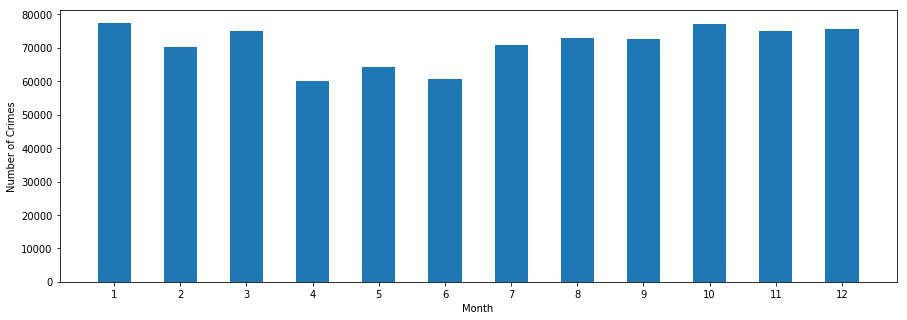

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,5])
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.bar(list(plot_data_month.keys()),list(plot_data_month.values()), width=0.5)

***Inference from the above plot is as follows***

We can see that plot for crimes at the start of the year is high and then it reduces to a considerable extent and then again starts to increase.

Thus crimes on the first 3 months is high and then it reduces for the next three months and then the values again increase for the consecutive months.

#### Task3: Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph.

In this task we have to find the number of crimes based on the suburbs. For this we first group the dataset based on the suburbs and the postcode. Then we would find the number of offences and after sorting we would find the top 20 suburbs based on the crime rate.

In [43]:
df_crime_suburb =   df_data_changed.groupBy(["Suburb - Incident", "Postcode - Incident"]).\
                        sum("Offence Count").\
                        sort('sum(Offence Count)', ascending = False).\
                        take(20)

Now that we have the top 20 suburbs based on the crime rates we now put this into a dictionary so that it would help us in plotting.

In [44]:
plot_suburb_data = {}
for i in df_crime_suburb:
    plot_suburb_data[str(i[0]) + " - "  +  str(i[1])] = i[2]

Now that we have the data for top 20 suburbs and the number of crimes we plot the data. We use a horizontal bar graph for the following plot. Matplotlib library is used for doing the plot.

<BarContainer object of 20 artists>

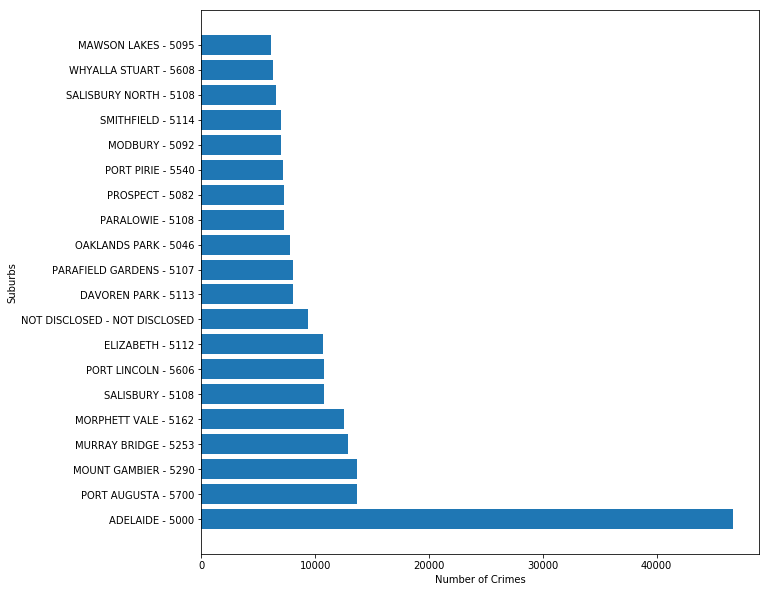

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.xlabel("Number of Crimes")
plt.ylabel("Suburbs")
plt.barh(list(plot_suburb_data.keys()), list(plot_suburb_data.values()))

***Inference from the above plot is as follows***

From the above plot we can see that Adelaide has the maximum number of crimes and this is followed by Port Augusta and Mount Gambier.

However we can see that the number of crimes in Adelaide is very very high. this can indicate that the something is seriously wrong in that region and the government should take immediate precationary steps to reduce crime rates in Adelaide.

#### Task4: Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

Now in this task our job would to plot the 'serious criminal trespasses' based on the month and the day. Thus we first filter the data based on the value and take all the rows which have the value 'SERIOUS CRIMINAL TRESPASS'.

In [46]:
df_serious_crime =  df_data_changed[df_data_changed['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS']

Now that we have the required data we would now group the data by month and day values and then find the number of serious criminal trespasses based on the day and month and store it as a list.

In [47]:
df_serious_crime_plot_month = df_serious_crime.groupBy(month('Reported Date').alias('month'), 
                dayofweek('Reported Date').
                alias('day')).sum('Offence Count').\
                sort("month","day", ascending = True).collect()

Now we create a list of lists based on the month and date values and this data is to be plotted.

In [48]:

serious_data_count = []

for i in range(12):
    serious_data_count.append([])

for i in df_serious_crime_plot_month:
        serious_data_count[i[0] - 1].append(i[2])

Now we have the required data to be plotted, hence we make line graphs based on the months. The plot is done using the Matplotlib library.

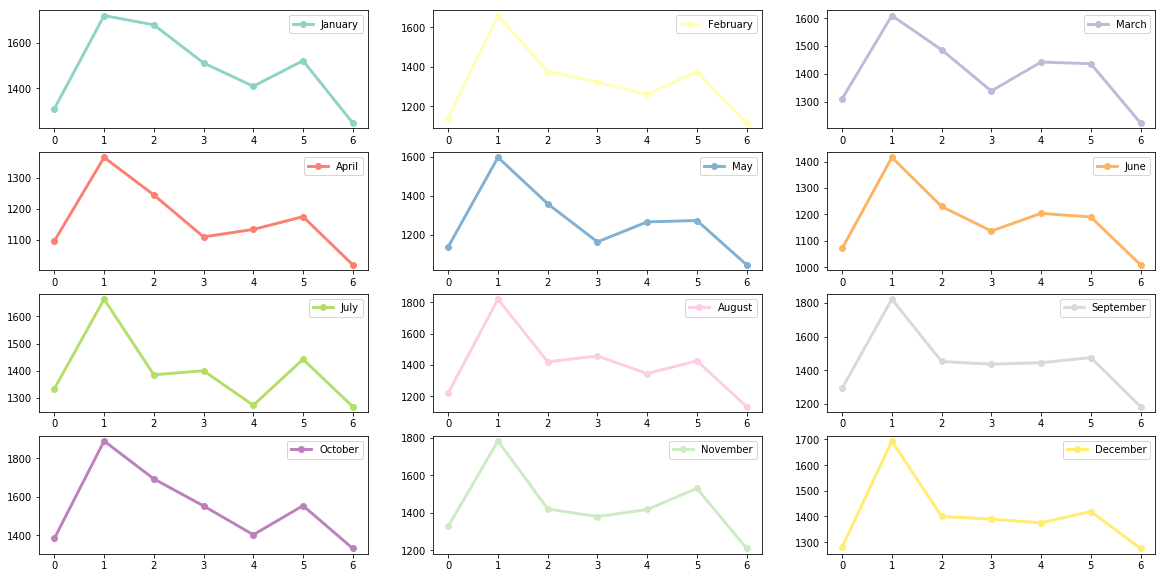

In [49]:
Month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
             'November', 'December']
plt.figure(figsize=(20,10))
palette = plt.get_cmap('Set3')

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(serious_data_count[i], color=palette(i), linewidth=2.9, label= Month_list[i], marker = 'o')
    plt.legend()

As seen from the above plot we can see that the plot is done for serious criminal trespasses based on the day of the week. We can see that the crime rates are less for the months April, May and June and they are the highest for the months October, November and December.

Also we can see that the first day of the week and the last day of the week has the lowest number of serious criminal tresspasses and the second day of the week has the highest number of serious criminal trespasses.

## References Used:

some codes from Monash University Lecture 2,3,4 has been used for this assignment. 